In [1]:
import ggcnn.experiment as experiment
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from collections import defaultdict


def load_sa1_dataset():
    keys_SA1 = []
    features_SA1 = []
    labels = []
    keys_SA2 = []
    features_SA2 = []
    
    # Load SA1 Node Features
    with open('Data/2018-09-02-NSW-SA1Input-Normalised.csv', 'r') as file:
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')  # Last value in line is \n
            keys_SA1.append(s[0])
            features_SA1.extend([float(v) for v in s[1:-1]])  # Last column is the outcome y
#             labels.append(np.floor(float(s[-1]) / 10).astype(int))
            labels.append(float(s[-1]))
    
    
    # Load SA2 Node Features
    with open('Data/2018-08-28-NSW-SA2Input-Normalised.csv', 'r') as file:
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')  # Last value in line is \n
            keys_SA2.append(s[0])
            features_SA2.extend([float(v) for v in s[1:-1]])  # Last column is the outcome y

    labels = np.array(labels)
    features_SA1 = np.array(features_SA1).reshape((len(keys_SA1), -1))
    features_SA2 = np.array(features_SA2).reshape((len(keys_SA2), -1))
    
    # Load SA1 Link Features
    with open('Data/Geography/2018-09-01-NSW-Neighbouring_Suburbs_With_Bridges-Filtered.csv', 'r') as file:
        adj_mat_SA1 = np.zeros((len(keys_SA1), len(keys_SA1)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA1.index(s[0])
            b = keys_SA1.index(s[1])
            adj_mat_SA1[a, b] = 1
            adj_mat_SA1[b, a] = 1
    

    # Load SA2 Link Features
    with open('Data/Geography/2018-09-01-SA2Neighbouring_Suburbs_With_Bridges-Filtered.csv', 'r') as file:
        adj_mat_SA2 = np.zeros((len(keys_SA2), len(keys_SA2)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA2.index(s[0])
            b = keys_SA2.index(s[1])
            adj_mat_SA2[a, b] = 1
            adj_mat_SA2[b, a] = 1
    
    
    # Load SA1, SA2 Links
    with open('Data/2018-09-02-SA1SA2Links.csv', 'r') as file:
        adj_mat_SA1SA2 = np.zeros((len(keys_SA1), len(keys_SA2)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA1.index(s[0])
            b = keys_SA2.index(s[1])
            adj_mat_SA1SA2[a, b] = 1
    
    adj_mat_SA2SA1 = np.transpose(adj_mat_SA1SA2)
    
    return (features_SA1, adj_mat_SA1, labels, features_SA2, adj_mat_SA2, adj_mat_SA1SA2, adj_mat_SA2SA1), (keys_SA1, keys_SA2)

dataset, keys = load_sa1_dataset()

/home/paperspace/anaconda3/envs/tf-gpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/tf-gpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
class SA1Experiment():
    def __init__(self, neurons, blocks, reverseLinkagePosition = "Early", linkagePosition = "Late",
                    linkageActFun = True, linkageBatchNorm = True, linkageNeurons = None,
                    auxilaryEmbedding1 = False, auxilaryEmbedding2 = False,
                    auxilaryGraph = False, linkage_adjustment_components = None):
        self.blocks = blocks
        self.neurons = neurons
        self.reverseLinkagePosition = reverseLinkagePosition
        self.linkagePosition = linkagePosition
        self.linkageActFun = linkageActFun
        self.linkageBatchNorm = linkageBatchNorm
        self.linkageNeurons = linkageNeurons
        self.auxilaryEmbedding1 = auxilaryEmbedding1
        self.auxilaryEmbedding2 = auxilaryEmbedding2
        self.auxilaryGraph = auxilaryGraph
        self.linkage_adjustment_components = linkage_adjustment_components
    
    def create_network(self, net, input):
        net.create_network(input)

        if self.linkage_adjustment_components is not None:
            net.make_linkage_adjustment_layer()
        
        if self.reverseLinkagePosition == "Early" or self.reverseLinkagePosition == "Both":
            net.make_reverse_auxilary_linkage_layer(self.linkageNeurons, with_act_func = self.linkageActFun, with_bn = self.linkageBatchNorm)
        if self.linkagePosition == "Early" or self.linkagePosition == "Both":
            net.make_auxilary_linkage_layer(self.linkageNeurons, with_act_func = self.linkageActFun, with_bn = self.linkageBatchNorm)
        
        net.make_embedding_layer(self.neurons)
        net.make_dropout_layer()
        
        for _ in range(self.blocks):
            net.make_graphcnn_layer(self.neurons)
            net.make_dropout_layer()
            net.make_embedding_layer(self.neurons)
            net.make_dropout_layer()
        
        if self.auxilaryEmbedding1:
            net.make_auxilary_embedding_layer(self.neurons)
            net.make_dropout_layer(input_type = 'current_V_auxilary')
        if self.reverseLinkagePosition == "Late" or self.reverseLinkagePosition == "Both":
            net.make_reverse_auxilary_linkage_layer(self.linkageNeurons, with_act_func = self.linkageActFun, with_bn = self.linkageBatchNorm)
        if self.auxilaryEmbedding2:
            net.make_auxilary_embedding_layer(self.neurons)
            net.make_dropout_layer(input_type = 'current_V_auxilary')
        if self.auxilaryGraph:
            net.make_auxilary_graphcnn_layer(self.neurons)
            net.make_dropout_layer(input_type = 'current_V_auxilary')
        if self.linkagePosition == "Late" or self.linkagePosition == "Both":
            net.make_auxilary_linkage_layer(self.linkageNeurons, with_act_func = self.linkageActFun, with_bn = self.linkageBatchNorm)
        
        net.make_embedding_layer(self.neurons)
        net.make_embedding_layer(1, name='final', with_bn=False, with_act_func = False)


######

def run(no_folds = 5, supervised = True, i = 0, l = 2, n = 128, expParameters = {}):
    inst = KFold(n_splits = no_folds, shuffle=True, random_state=125)
        
    exp = experiment.GGCNNExperiment('2018-08-28-SA1SA2', '2018-08-28-SA1SA2', SA1Experiment(neurons = n, blocks = l, **expParameters))

    exp.num_iterations = 5000
    exp.optimizer = 'adam'
    exp.loss_type = 'linear'

    exp.debug = True  # Was True

    exp.preprocess_data(dataset)

    valid_idx = np.flatnonzero(dataset[2] >= 0)  # Missing data labelled with -1
    if supervised:
        train_idx, test_idx = list(inst.split( valid_idx ))[i]
    else:
        test_idx, train_idx = list(inst.split( valid_idx ))[i]  # Reversed to get more samples in the test set than the training set

    n_components = expParameters.get('linkage_adjustment_components', None)
    exp.create_data(train_idx, test_idx, n_components = n_components)
    exp.build_network()
    results = exp.run()
    
    # Node type of input nodes: 0 = training set; 1 = test set; -1 = neither
    idx_split = np.empty((len(dataset[2]), 1))
    idx_split.fill(-1)
    idx_split[train_idx] = 0
    idx_split[test_idx] = 1

    return results, idx_split

In [13]:
expParameters = {"reverseLinkagePosition": "Early", "linkagePosition": "Late", "linkageActFun": False, "linkageBatchNorm": True,
                 "linkageNeurons": None, "auxilaryEmbedding1": False, "auxilaryEmbedding2": False, "auxilaryGraph": True,
                 "linkage_adjustment_components": 3}

results, idx_split = run(supervised = False, expParameters = expParameters)

2018-09-02 03:43:29.856494 Creating training Tensorflow Tensors
PCA variance ratio:  [0.17138445 0.12530963 0.08620866]
2018-09-02 03:43:29.992220 Creating training network
2018-09-02 03:43:30.903594 Creating loss function and summaries
2018-09-02 03:43:31.089888 Training model "2018-08-28-SA1SA2"!
2018-09-02 03:43:31.089997 Preparing training
2018-09-02 03:43:33.855414 Starting threads
2018-09-02 03:43:33.855581 Starting training. train_batch_size: 0 test_batch_size: 0
2018-09-02 03:43:34.800175 Test Step 0 Finished
2018-09-02 03:43:34.800299 Test Step 0 "min loss" =  4.0179608e+17
2018-09-02 03:43:34.800353 Test Step 0 "loss" =  4.0179608e+17
2018-09-02 03:43:37.791144 Training Step 0 Finished Timing (Training: 0.760064, Test: 0.23987) after 3.93478 seconds
2018-09-02 03:43:37.791270 Training Step 0 "min loss" =  2716.7556
2018-09-02 03:43:37.791340 Training Step 0 "loss" =  2716.7556
2018-09-02 03:43:38.427577 Test Step 5 Finished
2018-09-02 03:43:38.427694 Test Step 5 "min loss" = 

2018-09-02 03:43:52.550873 Test Step 95 Finished
2018-09-02 03:43:52.550960 Test Step 95 "min loss" =  1836.6749
2018-09-02 03:43:52.551745 Test Step 95 "loss" =  1836.6749
2018-09-02 03:43:52.695588 Training Step 95 Finished Timing (Training: 0.919694, Test: 0.0790509) after 0.778068 seconds
2018-09-02 03:43:52.695655 Training Step 95 "min loss" =  1855.4877
2018-09-02 03:43:52.695695 Training Step 95 "loss" =  1855.4877
2018-09-02 03:43:53.342520 Test Step 100 Finished
2018-09-02 03:43:53.342599 Test Step 100 "min loss" =  1800.9597
2018-09-02 03:43:53.342673 Test Step 100 "loss" =  1800.9597
2018-09-02 03:43:53.494693 Training Step 100 Finished Timing (Training: 0.919859, Test: 0.0788193) after 0.798063 seconds
2018-09-02 03:43:53.494755 Training Step 100 "min loss" =  1817.3055
2018-09-02 03:43:53.494802 Training Step 100 "loss" =  1817.3055
2018-09-02 03:43:54.134661 Test Step 105 Finished
2018-09-02 03:43:54.134753 Test Step 105 "min loss" =  1745.6259
2018-09-02 03:43:54.134839 

2018-09-02 03:44:08.215039 Test Step 195 Finished
2018-09-02 03:44:08.215143 Test Step 195 "min loss" =  1040.426
2018-09-02 03:44:08.215770 Test Step 195 "loss" =  1040.426
2018-09-02 03:44:08.366231 Training Step 195 Finished Timing (Training: 0.920776, Test: 0.0777771) after 0.783235 seconds
2018-09-02 03:44:08.366368 Training Step 195 "min loss" =  1034.5922
2018-09-02 03:44:08.366424 Training Step 195 "loss" =  1034.5922
2018-09-02 03:44:08.993591 Test Step 200 Finished
2018-09-02 03:44:08.993931 Test Step 200 "min loss" =  1017.2856
2018-09-02 03:44:08.993994 Test Step 200 "loss" =  1017.2856
2018-09-02 03:44:09.135781 Training Step 200 Finished Timing (Training: 0.920593, Test: 0.0779833) after 0.769294 seconds
2018-09-02 03:44:09.136060 Training Step 200 "min loss" =  998.33014
2018-09-02 03:44:09.136366 Training Step 200 "loss" =  998.33014
2018-09-02 03:44:09.766574 Test Step 205 Finished
2018-09-02 03:44:09.766669 Test Step 205 "min loss" =  991.8444
2018-09-02 03:44:09.7673

2018-09-02 03:44:23.966869 Test Step 295 Finished
2018-09-02 03:44:23.967038 Test Step 295 "min loss" =  465.27988
2018-09-02 03:44:23.967184 Test Step 295 "loss" =  465.27988
2018-09-02 03:44:24.109337 Training Step 295 Finished Timing (Training: 0.920141, Test: 0.0781921) after 0.798278 seconds
2018-09-02 03:44:24.109400 Training Step 295 "min loss" =  399.0815
2018-09-02 03:44:24.109893 Training Step 295 "loss" =  399.0815
2018-09-02 03:44:24.752132 Test Step 300 Finished
2018-09-02 03:44:24.752606 Test Step 300 "min loss" =  441.42545
2018-09-02 03:44:24.752669 Test Step 300 "loss" =  441.42545
2018-09-02 03:44:24.892070 Training Step 300 Finished Timing (Training: 0.91994, Test: 0.0783958) after 0.782098 seconds
2018-09-02 03:44:24.892135 Training Step 300 "min loss" =  376.82462
2018-09-02 03:44:24.892205 Training Step 300 "loss" =  376.82462
2018-09-02 03:44:25.519658 Test Step 305 Finished
2018-09-02 03:44:25.519762 Test Step 305 "min loss" =  415.89703
2018-09-02 03:44:25.5203

2018-09-02 03:44:39.682167 Test Step 395 Finished
2018-09-02 03:44:39.682607 Test Step 395 "min loss" =  182.2249
2018-09-02 03:44:39.682669 Test Step 395 "loss" =  182.2249
2018-09-02 03:44:39.828606 Training Step 395 Finished Timing (Training: 0.920619, Test: 0.0779792) after 0.794925 seconds
2018-09-02 03:44:39.828675 Training Step 395 "min loss" =  97.5112
2018-09-02 03:44:39.828734 Training Step 395 "loss" =  97.5112
2018-09-02 03:44:40.474404 Test Step 400 Finished
2018-09-02 03:44:40.474534 Test Step 400 "min loss" =  166.78708
2018-09-02 03:44:40.474591 Test Step 400 "loss" =  166.78708
2018-09-02 03:44:40.622538 Training Step 400 Finished Timing (Training: 0.920726, Test: 0.0779117) after 0.793741 seconds
2018-09-02 03:44:40.622602 Training Step 400 "min loss" =  91.79095
2018-09-02 03:44:40.622641 Training Step 400 "loss" =  91.79095
2018-09-02 03:44:41.260361 Test Step 405 Finished
2018-09-02 03:44:41.260837 Test Step 405 "min loss" =  155.83723
2018-09-02 03:44:41.260899 Te

2018-09-02 03:44:55.342417 Test Step 495 Finished
2018-09-02 03:44:55.342885 Test Step 495 "min loss" =  45.798225
2018-09-02 03:44:55.343132 Test Step 495 "loss" =  47.569366
2018-09-02 03:44:55.484900 Training Step 495 Finished Timing (Training: 0.921065, Test: 0.0774142) after 0.767017 seconds
2018-09-02 03:44:55.485162 Training Step 495 "min loss" =  23.500774
2018-09-02 03:44:55.485220 Training Step 495 "loss" =  24.568485
2018-09-02 03:44:56.122485 Test Step 500 Finished
2018-09-02 03:44:56.122786 Test Step 500 "min loss" =  45.798225
2018-09-02 03:44:56.123060 Test Step 500 "loss" =  47.263336
2018-09-02 03:44:56.266464 Training Step 500 Finished Timing (Training: 0.920606, Test: 0.0778583) after 0.781174 seconds
2018-09-02 03:44:56.266853 Training Step 500 "min loss" =  22.381872
2018-09-02 03:44:56.267380 Training Step 500 "loss" =  22.381872
2018-09-02 03:44:56.918840 Test Step 505 Finished
2018-09-02 03:44:56.919238 Test Step 505 "min loss" =  41.55907
2018-09-02 03:44:56.91

2018-09-02 03:45:10.220321 Test Step 590 Finished
2018-09-02 03:45:10.220419 Test Step 590 "min loss" =  15.084329
2018-09-02 03:45:10.220473 Test Step 590 "loss" =  15.084329
2018-09-02 03:45:10.364486 Training Step 590 Finished Timing (Training: 0.919559, Test: 0.0783916) after 0.789978 seconds
2018-09-02 03:45:10.364556 Training Step 590 "min loss" =  12.535976
2018-09-02 03:45:10.364608 Training Step 590 "loss" =  13.06788
2018-09-02 03:45:11.012165 Test Step 595 Finished
2018-09-02 03:45:11.012288 Test Step 595 "min loss" =  15.012782
2018-09-02 03:45:11.012937 Test Step 595 "loss" =  15.012782
2018-09-02 03:45:11.160641 Training Step 595 Finished Timing (Training: 0.919451, Test: 0.0785389) after 0.795959 seconds
2018-09-02 03:45:11.160804 Training Step 595 "min loss" =  12.535976
2018-09-02 03:45:11.160865 Training Step 595 "loss" =  13.287822
2018-09-02 03:45:11.800960 Test Step 600 Finished
2018-09-02 03:45:11.801427 Test Step 600 "min loss" =  15.012782
2018-09-02 03:45:11.80

2018-09-02 03:45:25.117685 Test Step 685 Finished
2018-09-02 03:45:25.117778 Test Step 685 "min loss" =  9.933361
2018-09-02 03:45:25.118276 Test Step 685 "loss" =  9.933361
2018-09-02 03:45:25.261708 Training Step 685 Finished Timing (Training: 0.921583, Test: 0.0768221) after 0.778161 seconds
2018-09-02 03:45:25.261782 Training Step 685 "min loss" =  10.003572
2018-09-02 03:45:25.261846 Training Step 685 "loss" =  10.381117
2018-09-02 03:45:25.915375 Test Step 690 Finished
2018-09-02 03:45:25.915497 Test Step 690 "min loss" =  9.933361
2018-09-02 03:45:25.915577 Test Step 690 "loss" =  10.278904
2018-09-02 03:45:26.059317 Training Step 690 Finished Timing (Training: 0.921607, Test: 0.0768197) after 0.796933 seconds
2018-09-02 03:45:26.059402 Training Step 690 "min loss" =  10.003572
2018-09-02 03:45:26.059838 Training Step 690 "loss" =  11.13826
2018-09-02 03:45:26.713879 Test Step 695 Finished
2018-09-02 03:45:26.714009 Test Step 695 "min loss" =  9.933361
2018-09-02 03:45:26.714097

2018-09-02 03:45:40.882055 Test Step 785 Finished
2018-09-02 03:45:40.882560 Test Step 785 "min loss" =  9.030276
2018-09-02 03:45:40.882628 Test Step 785 "loss" =  9.469858
2018-09-02 03:45:41.023432 Training Step 785 Finished Timing (Training: 0.918707, Test: 0.0797404) after 0.78665 seconds
2018-09-02 03:45:41.023710 Training Step 785 "min loss" =  8.810556
2018-09-02 03:45:41.023773 Training Step 785 "loss" =  9.074562
2018-09-02 03:45:41.659198 Test Step 790 Finished
2018-09-02 03:45:41.659684 Test Step 790 "min loss" =  9.030276
2018-09-02 03:45:41.659749 Test Step 790 "loss" =  9.333095
2018-09-02 03:45:41.800711 Training Step 790 Finished Timing (Training: 0.91873, Test: 0.0797288) after 0.776877 seconds
2018-09-02 03:45:41.800773 Training Step 790 "min loss" =  8.810556
2018-09-02 03:45:41.800812 Training Step 790 "loss" =  9.195736
2018-09-02 03:45:42.434685 Test Step 795 Finished
2018-09-02 03:45:42.435322 Test Step 795 "min loss" =  8.972392
2018-09-02 03:45:42.435386 Test 

2018-09-02 03:45:56.676589 Test Step 885 Finished
2018-09-02 03:45:56.676726 Test Step 885 "min loss" =  8.512789
2018-09-02 03:45:56.677238 Test Step 885 "loss" =  8.840404
2018-09-02 03:45:56.821584 Training Step 885 Finished Timing (Training: 0.918966, Test: 0.0789595) after 0.790395 seconds
2018-09-02 03:45:56.821649 Training Step 885 "min loss" =  7.846715
2018-09-02 03:45:56.821706 Training Step 885 "loss" =  8.103902
2018-09-02 03:45:57.462223 Test Step 890 Finished
2018-09-02 03:45:57.462676 Test Step 890 "min loss" =  8.512789
2018-09-02 03:45:57.462742 Test Step 890 "loss" =  9.481587
2018-09-02 03:45:57.610369 Training Step 890 Finished Timing (Training: 0.919023, Test: 0.0789609) after 0.788588 seconds
2018-09-02 03:45:57.610434 Training Step 890 "min loss" =  7.846715
2018-09-02 03:45:57.610544 Training Step 890 "loss" =  8.503866
2018-09-02 03:45:58.257520 Test Step 895 Finished
2018-09-02 03:45:58.257663 Test Step 895 "min loss" =  8.512789
2018-09-02 03:45:58.258169 Tes

2018-09-02 03:46:12.361648 Test Step 985 Finished
2018-09-02 03:46:12.361757 Test Step 985 "min loss" =  8.139859
2018-09-02 03:46:12.362246 Test Step 985 "loss" =  8.322662
2018-09-02 03:46:12.504117 Training Step 985 Finished Timing (Training: 0.9195, Test: 0.0785558) after 0.774841 seconds
2018-09-02 03:46:12.504392 Training Step 985 "min loss" =  7.3532968
2018-09-02 03:46:12.504448 Training Step 985 "loss" =  7.6216645
2018-09-02 03:46:13.165626 Test Step 990 Finished
2018-09-02 03:46:13.165727 Test Step 990 "min loss" =  8.139859
2018-09-02 03:46:13.166206 Test Step 990 "loss" =  8.275541
2018-09-02 03:46:13.314107 Training Step 990 Finished Timing (Training: 0.919896, Test: 0.078197) after 0.809602 seconds
2018-09-02 03:46:13.314173 Training Step 990 "min loss" =  7.3532968
2018-09-02 03:46:13.314224 Training Step 990 "loss" =  7.9409585
2018-09-02 03:46:13.961896 Test Step 995 Finished
2018-09-02 03:46:13.962361 Test Step 995 "min loss" =  8.139859
2018-09-02 03:46:13.962575 Te

2018-09-02 03:46:27.317926 Test Step 1080 Finished
2018-09-02 03:46:27.318035 Test Step 1080 "min loss" =  7.9379196
2018-09-02 03:46:27.318551 Test Step 1080 "loss" =  8.096303
2018-09-02 03:46:27.459631 Training Step 1080 Finished Timing (Training: 0.919558, Test: 0.0791138) after 0.786987 seconds
2018-09-02 03:46:27.459705 Training Step 1080 "min loss" =  7.0476584
2018-09-02 03:46:27.460225 Training Step 1080 "loss" =  7.0915666
2018-09-02 03:46:28.110656 Test Step 1085 Finished
2018-09-02 03:46:28.110739 Test Step 1085 "min loss" =  7.9379196
2018-09-02 03:46:28.111238 Test Step 1085 "loss" =  8.280115
2018-09-02 03:46:28.263009 Training Step 1085 Finished Timing (Training: 0.919578, Test: 0.0790741) after 0.802715 seconds
2018-09-02 03:46:28.263079 Training Step 1085 "min loss" =  7.0476584
2018-09-02 03:46:28.263702 Training Step 1085 "loss" =  7.11669
2018-09-02 03:46:28.897994 Test Step 1090 Finished
2018-09-02 03:46:28.898084 Test Step 1090 "min loss" =  7.9379196
2018-09-02 

2018-09-02 03:46:42.287720 Test Step 1175 Finished
2018-09-02 03:46:42.287872 Test Step 1175 "min loss" =  7.719307
2018-09-02 03:46:42.287953 Test Step 1175 "loss" =  8.121631
2018-09-02 03:46:42.430921 Training Step 1175 Finished Timing (Training: 0.920815, Test: 0.0778429) after 0.774879 seconds
2018-09-02 03:46:42.430995 Training Step 1175 "min loss" =  6.505491
2018-09-02 03:46:42.431032 Training Step 1175 "loss" =  6.8702564
2018-09-02 03:46:43.068159 Test Step 1180 Finished
2018-09-02 03:46:43.068258 Test Step 1180 "min loss" =  7.719307
2018-09-02 03:46:43.068301 Test Step 1180 "loss" =  7.8636165
2018-09-02 03:46:43.213995 Training Step 1180 Finished Timing (Training: 0.920837, Test: 0.0778731) after 0.782919 seconds
2018-09-02 03:46:43.214052 Training Step 1180 "min loss" =  6.505491
2018-09-02 03:46:43.214090 Training Step 1180 "loss" =  6.611815
2018-09-02 03:46:43.858531 Test Step 1185 Finished
2018-09-02 03:46:43.858902 Test Step 1185 "min loss" =  7.719307
2018-09-02 03:

2018-09-02 03:46:57.230224 Test Step 1270 Finished
2018-09-02 03:46:57.230677 Test Step 1270 "min loss" =  7.3972964
2018-09-02 03:46:57.230967 Test Step 1270 "loss" =  7.3972964
2018-09-02 03:46:57.377555 Training Step 1270 Finished Timing (Training: 0.920406, Test: 0.0780818) after 0.794652 seconds
2018-09-02 03:46:57.377808 Training Step 1270 "min loss" =  6.21769
2018-09-02 03:46:57.378092 Training Step 1270 "loss" =  6.6459384
2018-09-02 03:46:57.996047 Test Step 1275 Finished
2018-09-02 03:46:57.996479 Test Step 1275 "min loss" =  7.3972964
2018-09-02 03:46:57.996768 Test Step 1275 "loss" =  7.713557
2018-09-02 03:46:58.137581 Training Step 1275 Finished Timing (Training: 0.919846, Test: 0.0785815) after 0.759203 seconds
2018-09-02 03:46:58.137837 Training Step 1275 "min loss" =  6.21769
2018-09-02 03:46:58.138125 Training Step 1275 "loss" =  6.5187674
2018-09-02 03:46:58.788078 Test Step 1280 Finished
2018-09-02 03:46:58.788149 Test Step 1280 "min loss" =  7.3972964
2018-09-02 0

2018-09-02 03:47:12.210471 Test Step 1365 Finished
2018-09-02 03:47:12.210591 Test Step 1365 "min loss" =  7.369645
2018-09-02 03:47:12.210637 Test Step 1365 "loss" =  7.369645
2018-09-02 03:47:12.358732 Training Step 1365 Finished Timing (Training: 0.920006, Test: 0.079038) after 0.813141 seconds
2018-09-02 03:47:12.358796 Training Step 1365 "min loss" =  5.7911725
2018-09-02 03:47:12.358838 Training Step 1365 "loss" =  6.535032
2018-09-02 03:47:13.017141 Test Step 1370 Finished
2018-09-02 03:47:13.017250 Test Step 1370 "min loss" =  7.369645
2018-09-02 03:47:13.017333 Test Step 1370 "loss" =  7.441389
2018-09-02 03:47:13.165470 Training Step 1370 Finished Timing (Training: 0.920389, Test: 0.078686) after 0.806575 seconds
2018-09-02 03:47:13.165591 Training Step 1370 "min loss" =  5.7911725
2018-09-02 03:47:13.165635 Training Step 1370 "loss" =  6.0940065
2018-09-02 03:47:13.829034 Test Step 1375 Finished
2018-09-02 03:47:13.829128 Test Step 1375 "min loss" =  7.369645
2018-09-02 03:4

2018-09-02 03:47:27.546604 Test Step 1460 Finished
2018-09-02 03:47:27.546772 Test Step 1460 "min loss" =  7.347228
2018-09-02 03:47:27.546832 Test Step 1460 "loss" =  7.5437956
2018-09-02 03:47:27.697924 Training Step 1460 Finished Timing (Training: 0.919543, Test: 0.0799399) after 0.809775 seconds
2018-09-02 03:47:27.697985 Training Step 1460 "min loss" =  5.47215
2018-09-02 03:47:27.698021 Training Step 1460 "loss" =  5.7176633
2018-09-02 03:47:28.352414 Test Step 1465 Finished
2018-09-02 03:47:28.352845 Test Step 1465 "min loss" =  7.347228
2018-09-02 03:47:28.353135 Test Step 1465 "loss" =  8.044652
2018-09-02 03:47:28.506023 Training Step 1465 Finished Timing (Training: 0.919679, Test: 0.0797295) after 0.80796 seconds
2018-09-02 03:47:28.506273 Training Step 1465 "min loss" =  5.47215
2018-09-02 03:47:28.506558 Training Step 1465 "loss" =  5.9730825
2018-09-02 03:47:29.149512 Test Step 1470 Finished
2018-09-02 03:47:29.149972 Test Step 1470 "min loss" =  7.342845
2018-09-02 03:47

2018-09-02 03:47:42.880725 Test Step 1555 Finished
2018-09-02 03:47:42.881111 Test Step 1555 "min loss" =  7.342845
2018-09-02 03:47:42.881457 Test Step 1555 "loss" =  7.4110465
2018-09-02 03:47:43.031970 Training Step 1555 Finished Timing (Training: 0.921299, Test: 0.0777969) after 0.803679 seconds
2018-09-02 03:47:43.032227 Training Step 1555 "min loss" =  5.358497
2018-09-02 03:47:43.032517 Training Step 1555 "loss" =  5.5401306
2018-09-02 03:47:43.693456 Test Step 1560 Finished
2018-09-02 03:47:43.693930 Test Step 1560 "min loss" =  7.342845
2018-09-02 03:47:43.694217 Test Step 1560 "loss" =  7.4223266
2018-09-02 03:47:43.843944 Training Step 1560 Finished Timing (Training: 0.920811, Test: 0.0781626) after 0.811141 seconds
2018-09-02 03:47:43.844233 Training Step 1560 "min loss" =  5.358497
2018-09-02 03:47:43.844521 Training Step 1560 "loss" =  5.5404034
2018-09-02 03:47:44.491297 Test Step 1565 Finished
2018-09-02 03:47:44.491730 Test Step 1565 "min loss" =  7.2648935
2018-09-02 

2018-09-02 03:47:58.177773 Test Step 1650 Finished
2018-09-02 03:47:58.177838 Test Step 1650 "min loss" =  7.124336
2018-09-02 03:47:58.177879 Test Step 1650 "loss" =  7.5825415
2018-09-02 03:47:58.324376 Training Step 1650 Finished Timing (Training: 0.920312, Test: 0.0782894) after 0.795149 seconds
2018-09-02 03:47:58.324435 Training Step 1650 "min loss" =  5.187078
2018-09-02 03:47:58.324476 Training Step 1650 "loss" =  5.2744613
2018-09-02 03:47:58.978301 Test Step 1655 Finished
2018-09-02 03:47:58.978406 Test Step 1655 "min loss" =  7.124336
2018-09-02 03:47:58.978452 Test Step 1655 "loss" =  7.532448
2018-09-02 03:47:59.122256 Training Step 1655 Finished Timing (Training: 0.920117, Test: 0.078568) after 0.797734 seconds
2018-09-02 03:47:59.122316 Training Step 1655 "min loss" =  5.187078
2018-09-02 03:47:59.122356 Training Step 1655 "loss" =  5.5990634
2018-09-02 03:47:59.780560 Test Step 1660 Finished
2018-09-02 03:47:59.780646 Test Step 1660 "min loss" =  7.124336
2018-09-02 03:

2018-09-02 03:48:13.705502 Test Step 1745 Finished
2018-09-02 03:48:13.705584 Test Step 1745 "min loss" =  7.124336
2018-09-02 03:48:13.705628 Test Step 1745 "loss" =  7.357837
2018-09-02 03:48:13.853676 Training Step 1745 Finished Timing (Training: 0.92016, Test: 0.0793648) after 0.821352 seconds
2018-09-02 03:48:13.853736 Training Step 1745 "min loss" =  4.903375
2018-09-02 03:48:13.853778 Training Step 1745 "loss" =  5.2857165
2018-09-02 03:48:14.519482 Test Step 1750 Finished
2018-09-02 03:48:14.519596 Test Step 1750 "min loss" =  7.124336
2018-09-02 03:48:14.519640 Test Step 1750 "loss" =  7.337637
2018-09-02 03:48:14.664435 Training Step 1750 Finished Timing (Training: 0.9201, Test: 0.0794232) after 0.810608 seconds
2018-09-02 03:48:14.664491 Training Step 1750 "min loss" =  4.903375
2018-09-02 03:48:14.664527 Training Step 1750 "loss" =  5.2127695
2018-09-02 03:48:15.328276 Test Step 1755 Finished
2018-09-02 03:48:15.328383 Test Step 1755 "min loss" =  7.124336
2018-09-02 03:48:

2018-09-02 03:48:29.282661 Test Step 1840 Finished
2018-09-02 03:48:29.283013 Test Step 1840 "min loss" =  7.124336
2018-09-02 03:48:29.283301 Test Step 1840 "loss" =  7.1967173
2018-09-02 03:48:29.434593 Training Step 1840 Finished Timing (Training: 0.919799, Test: 0.0788956) after 0.807504 seconds
2018-09-02 03:48:29.434950 Training Step 1840 "min loss" =  4.624073
2018-09-02 03:48:29.435240 Training Step 1840 "loss" =  4.879271
2018-09-02 03:48:30.089690 Test Step 1845 Finished
2018-09-02 03:48:30.090182 Test Step 1845 "min loss" =  7.124336
2018-09-02 03:48:30.090471 Test Step 1845 "loss" =  7.3844337
2018-09-02 03:48:30.241726 Training Step 1845 Finished Timing (Training: 0.919742, Test: 0.0788174) after 0.806202 seconds
2018-09-02 03:48:30.241977 Training Step 1845 "min loss" =  4.624073
2018-09-02 03:48:30.242263 Training Step 1845 "loss" =  5.1275992
2018-09-02 03:48:30.904376 Test Step 1850 Finished
2018-09-02 03:48:30.904819 Test Step 1850 "min loss" =  7.124336
2018-09-02 03

2018-09-02 03:48:44.627873 Test Step 1935 Finished
2018-09-02 03:48:44.627950 Test Step 1935 "min loss" =  7.124336
2018-09-02 03:48:44.627991 Test Step 1935 "loss" =  7.4573135
2018-09-02 03:48:44.778408 Training Step 1935 Finished Timing (Training: 0.920561, Test: 0.0779226) after 0.812319 seconds
2018-09-02 03:48:44.778520 Training Step 1935 "min loss" =  4.5849
2018-09-02 03:48:44.778564 Training Step 1935 "loss" =  4.91656
2018-09-02 03:48:45.434684 Test Step 1940 Finished
2018-09-02 03:48:45.434784 Test Step 1940 "min loss" =  7.124336
2018-09-02 03:48:45.434828 Test Step 1940 "loss" =  7.6131907
2018-09-02 03:48:45.583419 Training Step 1940 Finished Timing (Training: 0.920564, Test: 0.0780439) after 0.804811 seconds
2018-09-02 03:48:45.583473 Training Step 1940 "min loss" =  4.5849
2018-09-02 03:48:45.583509 Training Step 1940 "loss" =  4.9879174
2018-09-02 03:48:46.236514 Test Step 1945 Finished
2018-09-02 03:48:46.236620 Test Step 1945 "min loss" =  7.124336
2018-09-02 03:48:4

2018-09-02 03:48:59.962276 Test Step 2030 Finished
2018-09-02 03:48:59.962771 Test Step 2030 "min loss" =  7.124336
2018-09-02 03:48:59.963091 Test Step 2030 "loss" =  7.574427
2018-09-02 03:49:00.114409 Training Step 2030 Finished Timing (Training: 0.919638, Test: 0.0782305) after 0.811401 seconds
2018-09-02 03:49:00.114746 Training Step 2030 "min loss" =  4.3553014
2018-09-02 03:49:00.115031 Training Step 2030 "loss" =  4.898402
2018-09-02 03:49:00.783431 Test Step 2035 Finished
2018-09-02 03:49:00.783878 Test Step 2035 "min loss" =  7.124336
2018-09-02 03:49:00.784168 Test Step 2035 "loss" =  7.5669527
2018-09-02 03:49:00.933547 Training Step 2035 Finished Timing (Training: 0.919369, Test: 0.0784611) after 0.818233 seconds
2018-09-02 03:49:00.933796 Training Step 2035 "min loss" =  4.3553014
2018-09-02 03:49:00.934079 Training Step 2035 "loss" =  4.7032895
2018-09-02 03:49:01.598845 Test Step 2040 Finished
2018-09-02 03:49:01.599182 Test Step 2040 "min loss" =  7.124336
2018-09-02 0

2018-09-02 03:49:15.472878 Test Step 2125 Finished
2018-09-02 03:49:15.473342 Test Step 2125 "min loss" =  7.1077833
2018-09-02 03:49:15.473634 Test Step 2125 "loss" =  7.709696
2018-09-02 03:49:15.622573 Training Step 2125 Finished Timing (Training: 0.919729, Test: 0.0781571) after 0.815265 seconds
2018-09-02 03:49:15.622826 Training Step 2125 "min loss" =  4.2683353
2018-09-02 03:49:15.623130 Training Step 2125 "loss" =  4.7273383
2018-09-02 03:49:16.278724 Test Step 2130 Finished
2018-09-02 03:49:16.279194 Test Step 2130 "min loss" =  7.1077833
2018-09-02 03:49:16.279486 Test Step 2130 "loss" =  7.1867504
2018-09-02 03:49:16.437386 Training Step 2130 Finished Timing (Training: 0.919437, Test: 0.0784019) after 0.813936 seconds
2018-09-02 03:49:16.437688 Training Step 2130 "min loss" =  4.2683353
2018-09-02 03:49:16.437991 Training Step 2130 "loss" =  4.4563594
2018-09-02 03:49:17.092632 Test Step 2135 Finished
2018-09-02 03:49:17.093061 Test Step 2135 "min loss" =  7.1077833
2018-09-

2018-09-02 03:49:30.991739 Test Step 2220 Finished
2018-09-02 03:49:30.992178 Test Step 2220 "min loss" =  7.008738
2018-09-02 03:49:30.992472 Test Step 2220 "loss" =  7.0636706
2018-09-02 03:49:31.146630 Training Step 2220 Finished Timing (Training: 0.918559, Test: 0.0793847) after 0.824039 seconds
2018-09-02 03:49:31.146897 Training Step 2220 "min loss" =  4.0697813
2018-09-02 03:49:31.147187 Training Step 2220 "loss" =  4.267647
2018-09-02 03:49:31.794188 Test Step 2225 Finished
2018-09-02 03:49:31.794650 Test Step 2225 "min loss" =  7.008738
2018-09-02 03:49:31.794933 Test Step 2225 "loss" =  7.309818
2018-09-02 03:49:31.949569 Training Step 2225 Finished Timing (Training: 0.918438, Test: 0.0794293) after 0.802093 seconds
2018-09-02 03:49:31.949864 Training Step 2225 "min loss" =  4.0697813
2018-09-02 03:49:31.950163 Training Step 2225 "loss" =  4.382016
2018-09-02 03:49:32.617220 Test Step 2230 Finished
2018-09-02 03:49:32.617707 Test Step 2230 "min loss" =  7.008738
2018-09-02 03

2018-09-02 03:49:46.475124 Test Step 2315 Finished
2018-09-02 03:49:46.475577 Test Step 2315 "min loss" =  7.008738
2018-09-02 03:49:46.475911 Test Step 2315 "loss" =  7.247359
2018-09-02 03:49:46.627291 Training Step 2315 Finished Timing (Training: 0.917179, Test: 0.0804631) after 0.822967 seconds
2018-09-02 03:49:46.627575 Training Step 2315 "min loss" =  4.0527625
2018-09-02 03:49:46.627890 Training Step 2315 "loss" =  4.3031926
2018-09-02 03:49:47.291192 Test Step 2320 Finished
2018-09-02 03:49:47.291645 Test Step 2320 "min loss" =  7.008738
2018-09-02 03:49:47.291963 Test Step 2320 "loss" =  7.2089205
2018-09-02 03:49:47.443558 Training Step 2320 Finished Timing (Training: 0.918255, Test: 0.0793508) after 0.815351 seconds
2018-09-02 03:49:47.443837 Training Step 2320 "min loss" =  4.0527625
2018-09-02 03:49:47.444180 Training Step 2320 "loss" =  4.743185
2018-09-02 03:49:48.103019 Test Step 2325 Finished
2018-09-02 03:49:48.103439 Test Step 2325 "min loss" =  7.008738
2018-09-02 0

2018-09-02 03:50:01.959049 Test Step 2410 Finished
2018-09-02 03:50:01.959548 Test Step 2410 "min loss" =  7.008738
2018-09-02 03:50:01.959658 Test Step 2410 "loss" =  7.4029603
2018-09-02 03:50:02.112112 Training Step 2410 Finished Timing (Training: 0.91922, Test: 0.0801261) after 0.815443 seconds
2018-09-02 03:50:02.112465 Training Step 2410 "min loss" =  3.925944
2018-09-02 03:50:02.112621 Training Step 2410 "loss" =  4.3580756
2018-09-02 03:50:02.783766 Test Step 2415 Finished
2018-09-02 03:50:02.784226 Test Step 2415 "min loss" =  7.008738
2018-09-02 03:50:02.784574 Test Step 2415 "loss" =  7.4176016
2018-09-02 03:50:02.936003 Training Step 2415 Finished Timing (Training: 0.918577, Test: 0.0802856) after 0.823332 seconds
2018-09-02 03:50:02.936277 Training Step 2415 "min loss" =  3.925944
2018-09-02 03:50:02.936591 Training Step 2415 "loss" =  4.4121604
2018-09-02 03:50:03.606548 Test Step 2420 Finished
2018-09-02 03:50:03.606966 Test Step 2420 "min loss" =  7.008738
2018-09-02 03

2018-09-02 03:50:17.449588 Test Step 2505 Finished
2018-09-02 03:50:17.449700 Test Step 2505 "min loss" =  7.008738
2018-09-02 03:50:17.449762 Test Step 2505 "loss" =  7.608275
2018-09-02 03:50:17.600853 Training Step 2505 Finished Timing (Training: 0.919217, Test: 0.0795256) after 0.815413 seconds
2018-09-02 03:50:17.600936 Training Step 2505 "min loss" =  3.7347872
2018-09-02 03:50:17.600990 Training Step 2505 "loss" =  4.139918
2018-09-02 03:50:18.259652 Test Step 2510 Finished
2018-09-02 03:50:18.259752 Test Step 2510 "min loss" =  7.008738
2018-09-02 03:50:18.260223 Test Step 2510 "loss" =  7.652548
2018-09-02 03:50:18.416256 Training Step 2510 Finished Timing (Training: 0.920102, Test: 0.0785023) after 0.815189 seconds
2018-09-02 03:50:18.416326 Training Step 2510 "min loss" =  3.7347872
2018-09-02 03:50:18.416379 Training Step 2510 "loss" =  4.1637034
2018-09-02 03:50:19.088906 Test Step 2515 Finished
2018-09-02 03:50:19.089014 Test Step 2515 "min loss" =  7.008738
2018-09-02 03

2018-09-02 03:50:32.922129 Test Step 2600 Finished
2018-09-02 03:50:32.922589 Test Step 2600 "min loss" =  7.008738
2018-09-02 03:50:32.922781 Test Step 2600 "loss" =  7.499942
2018-09-02 03:50:33.076928 Training Step 2600 Finished Timing (Training: 0.919141, Test: 0.0792953) after 0.820392 seconds
2018-09-02 03:50:33.077133 Training Step 2600 "min loss" =  3.5662894
2018-09-02 03:50:33.077185 Training Step 2600 "loss" =  3.8988664
2018-09-02 03:50:33.750423 Test Step 2605 Finished
2018-09-02 03:50:33.750536 Test Step 2605 "min loss" =  7.008738
2018-09-02 03:50:33.751009 Test Step 2605 "loss" =  7.463138
2018-09-02 03:50:33.901852 Training Step 2605 Finished Timing (Training: 0.916696, Test: 0.0822016) after 0.824095 seconds
2018-09-02 03:50:33.901939 Training Step 2605 "min loss" =  3.5662894
2018-09-02 03:50:33.902340 Training Step 2605 "loss" =  4.252719
2018-09-02 03:50:34.561125 Test Step 2610 Finished
2018-09-02 03:50:34.561243 Test Step 2610 "min loss" =  7.008738
2018-09-02 03

2018-09-02 03:50:48.380778 Test Step 2695 Finished
2018-09-02 03:50:48.380898 Test Step 2695 "min loss" =  7.008738
2018-09-02 03:50:48.381548 Test Step 2695 "loss" =  8.091732
2018-09-02 03:50:48.538801 Training Step 2695 Finished Timing (Training: 0.919134, Test: 0.0792965) after 0.829627 seconds
2018-09-02 03:50:48.538885 Training Step 2695 "min loss" =  3.5662894
2018-09-02 03:50:48.538938 Training Step 2695 "loss" =  3.7849183
2018-09-02 03:50:49.204206 Test Step 2700 Finished
2018-09-02 03:50:49.204311 Test Step 2700 "min loss" =  7.008738
2018-09-02 03:50:49.204942 Test Step 2700 "loss" =  7.4792414
2018-09-02 03:50:49.352542 Training Step 2700 Finished Timing (Training: 0.918928, Test: 0.0794776) after 0.813022 seconds
2018-09-02 03:50:49.352627 Training Step 2700 "min loss" =  3.5662894
2018-09-02 03:50:49.352680 Training Step 2700 "loss" =  4.050746
2018-09-02 03:50:50.012005 Test Step 2705 Finished
2018-09-02 03:50:50.012118 Test Step 2705 "min loss" =  7.008738
2018-09-02 0

2018-09-02 03:51:03.872398 Test Step 2790 Finished
2018-09-02 03:51:03.872905 Test Step 2790 "min loss" =  7.008738
2018-09-02 03:51:03.872972 Test Step 2790 "loss" =  8.069674
2018-09-02 03:51:04.020293 Training Step 2790 Finished Timing (Training: 0.918742, Test: 0.0791641) after 0.804713 seconds
2018-09-02 03:51:04.020406 Training Step 2790 "min loss" =  3.5347595
2018-09-02 03:51:04.020461 Training Step 2790 "loss" =  3.7864377
2018-09-02 03:51:04.685815 Test Step 2795 Finished
2018-09-02 03:51:04.685921 Test Step 2795 "min loss" =  7.008738
2018-09-02 03:51:04.685983 Test Step 2795 "loss" =  7.3628616
2018-09-02 03:51:04.836505 Training Step 2795 Finished Timing (Training: 0.91869, Test: 0.0792494) after 0.815971 seconds
2018-09-02 03:51:04.836643 Training Step 2795 "min loss" =  3.5347595
2018-09-02 03:51:04.836698 Training Step 2795 "loss" =  3.7988334
2018-09-02 03:51:05.496614 Test Step 2800 Finished
2018-09-02 03:51:05.496720 Test Step 2800 "min loss" =  7.008738
2018-09-02 0

2018-09-02 03:51:19.366912 Test Step 2885 Finished
2018-09-02 03:51:19.367001 Test Step 2885 "min loss" =  7.008738
2018-09-02 03:51:19.367686 Test Step 2885 "loss" =  8.093707
2018-09-02 03:51:19.516355 Training Step 2885 Finished Timing (Training: 0.919326, Test: 0.0793356) after 0.81793 seconds
2018-09-02 03:51:19.516424 Training Step 2885 "min loss" =  3.4093852
2018-09-02 03:51:19.516474 Training Step 2885 "loss" =  3.6974194
2018-09-02 03:51:20.168714 Test Step 2890 Finished
2018-09-02 03:51:20.168800 Test Step 2890 "min loss" =  7.008738
2018-09-02 03:51:20.168862 Test Step 2890 "loss" =  7.6905684
2018-09-02 03:51:20.319890 Training Step 2890 Finished Timing (Training: 0.919545, Test: 0.0791596) after 0.803359 seconds
2018-09-02 03:51:20.319954 Training Step 2890 "min loss" =  3.4093852
2018-09-02 03:51:20.320011 Training Step 2890 "loss" =  3.565707
2018-09-02 03:51:20.990613 Test Step 2895 Finished
2018-09-02 03:51:20.991039 Test Step 2895 "min loss" =  7.008738
2018-09-02 03

2018-09-02 03:51:34.838530 Test Step 2980 Finished
2018-09-02 03:51:34.838655 Test Step 2980 "min loss" =  7.008738
2018-09-02 03:51:34.839307 Test Step 2980 "loss" =  7.3605075
2018-09-02 03:51:34.992936 Training Step 2980 Finished Timing (Training: 0.920773, Test: 0.0779378) after 0.819312 seconds
2018-09-02 03:51:34.992999 Training Step 2980 "min loss" =  3.317803
2018-09-02 03:51:34.993402 Training Step 2980 "loss" =  3.6746662
2018-09-02 03:51:35.650366 Test Step 2985 Finished
2018-09-02 03:51:35.650712 Test Step 2985 "min loss" =  7.008738
2018-09-02 03:51:35.650906 Test Step 2985 "loss" =  7.899947
2018-09-02 03:51:35.799492 Training Step 2985 Finished Timing (Training: 0.920867, Test: 0.0778367) after 0.806032 seconds
2018-09-02 03:51:35.799549 Training Step 2985 "min loss" =  3.317803
2018-09-02 03:51:35.799905 Training Step 2985 "loss" =  3.668525
2018-09-02 03:51:36.462099 Test Step 2990 Finished
2018-09-02 03:51:36.462218 Test Step 2990 "min loss" =  7.008738
2018-09-02 03:

2018-09-02 03:51:50.363069 Test Step 3075 Finished
2018-09-02 03:51:50.363408 Test Step 3075 "min loss" =  7.008738
2018-09-02 03:51:50.363853 Test Step 3075 "loss" =  7.780999
2018-09-02 03:51:50.511406 Training Step 3075 Finished Timing (Training: 0.919978, Test: 0.0783523) after 0.800565 seconds
2018-09-02 03:51:50.511548 Training Step 3075 "min loss" =  3.2563245
2018-09-02 03:51:50.512076 Training Step 3075 "loss" =  3.571171
2018-09-02 03:51:51.171677 Test Step 3080 Finished
2018-09-02 03:51:51.171956 Test Step 3080 "min loss" =  7.008738
2018-09-02 03:51:51.172226 Test Step 3080 "loss" =  7.55005
2018-09-02 03:51:51.322663 Training Step 3080 Finished Timing (Training: 0.920195, Test: 0.0781154) after 0.810279 seconds
2018-09-02 03:51:51.322745 Training Step 3080 "min loss" =  3.2563245
2018-09-02 03:51:51.322800 Training Step 3080 "loss" =  3.536811
2018-09-02 03:51:51.983721 Test Step 3085 Finished
2018-09-02 03:51:51.983831 Test Step 3085 "min loss" =  7.008738
2018-09-02 03:5

2018-09-02 03:52:05.790294 Test Step 3170 Finished
2018-09-02 03:52:05.790696 Test Step 3170 "min loss" =  7.008738
2018-09-02 03:52:05.791025 Test Step 3170 "loss" =  7.6107583
2018-09-02 03:52:05.941262 Training Step 3170 Finished Timing (Training: 0.919531, Test: 0.0791233) after 0.814284 seconds
2018-09-02 03:52:05.941598 Training Step 3170 "min loss" =  3.185923
2018-09-02 03:52:05.941885 Training Step 3170 "loss" =  3.3953962
2018-09-02 03:52:06.610834 Test Step 3175 Finished
2018-09-02 03:52:06.611271 Test Step 3175 "min loss" =  7.008738
2018-09-02 03:52:06.611558 Test Step 3175 "loss" =  7.5066814
2018-09-02 03:52:06.756476 Training Step 3175 Finished Timing (Training: 0.919446, Test: 0.079137) after 0.814302 seconds
2018-09-02 03:52:06.756728 Training Step 3175 "min loss" =  3.185923
2018-09-02 03:52:06.757017 Training Step 3175 "loss" =  3.4549148
2018-09-02 03:52:07.423035 Test Step 3180 Finished
2018-09-02 03:52:07.423413 Test Step 3180 "min loss" =  7.008738
2018-09-02 03

2018-09-02 03:52:21.285386 Test Step 3265 Finished
2018-09-02 03:52:21.285491 Test Step 3265 "min loss" =  7.008738
2018-09-02 03:52:21.285537 Test Step 3265 "loss" =  8.092419
2018-09-02 03:52:21.437340 Training Step 3265 Finished Timing (Training: 0.919795, Test: 0.0783504) after 0.814708 seconds
2018-09-02 03:52:21.437413 Training Step 3265 "min loss" =  3.1646225
2018-09-02 03:52:21.437453 Training Step 3265 "loss" =  3.1646225
2018-09-02 03:52:22.118378 Test Step 3270 Finished
2018-09-02 03:52:22.118491 Test Step 3270 "min loss" =  7.008738
2018-09-02 03:52:22.118553 Test Step 3270 "loss" =  8.09107
2018-09-02 03:52:22.266079 Training Step 3270 Finished Timing (Training: 0.919663, Test: 0.0785814) after 0.828582 seconds
2018-09-02 03:52:22.266136 Training Step 3270 "min loss" =  3.1646225
2018-09-02 03:52:22.266172 Training Step 3270 "loss" =  3.4277484
2018-09-02 03:52:22.930473 Test Step 3275 Finished
2018-09-02 03:52:22.930895 Test Step 3275 "min loss" =  7.008738
2018-09-02 03

2018-09-02 03:52:36.776815 Test Step 3360 Finished
2018-09-02 03:52:36.776918 Test Step 3360 "min loss" =  7.008738
2018-09-02 03:52:36.776964 Test Step 3360 "loss" =  7.6113324
2018-09-02 03:52:36.927472 Training Step 3360 Finished Timing (Training: 0.919143, Test: 0.0789473) after 0.809212 seconds
2018-09-02 03:52:36.927586 Training Step 3360 "min loss" =  2.937697
2018-09-02 03:52:36.927628 Training Step 3360 "loss" =  3.2224934
2018-09-02 03:52:37.601125 Test Step 3365 Finished
2018-09-02 03:52:37.601215 Test Step 3365 "min loss" =  7.008738
2018-09-02 03:52:37.601262 Test Step 3365 "loss" =  8.700525
2018-09-02 03:52:37.743947 Training Step 3365 Finished Timing (Training: 0.919051, Test: 0.079142) after 0.816262 seconds
2018-09-02 03:52:37.744092 Training Step 3365 "min loss" =  2.937697
2018-09-02 03:52:37.744139 Training Step 3365 "loss" =  3.4745598
2018-09-02 03:52:38.419052 Test Step 3370 Finished
2018-09-02 03:52:38.419490 Test Step 3370 "min loss" =  7.008738
2018-09-02 03:

2018-09-02 03:52:52.351627 Test Step 3455 Finished
2018-09-02 03:52:52.352078 Test Step 3455 "min loss" =  7.008738
2018-09-02 03:52:52.352398 Test Step 3455 "loss" =  7.78105
2018-09-02 03:52:52.503729 Training Step 3455 Finished Timing (Training: 0.91827, Test: 0.0792264) after 0.823015 seconds
2018-09-02 03:52:52.504119 Training Step 3455 "min loss" =  2.8953269
2018-09-02 03:52:52.504441 Training Step 3455 "loss" =  3.4407365
2018-09-02 03:52:53.175890 Test Step 3460 Finished
2018-09-02 03:52:53.176338 Test Step 3460 "min loss" =  7.008738
2018-09-02 03:52:53.176657 Test Step 3460 "loss" =  8.416797
2018-09-02 03:52:53.328233 Training Step 3460 Finished Timing (Training: 0.91823, Test: 0.0792571) after 0.823472 seconds
2018-09-02 03:52:53.328502 Training Step 3460 "min loss" =  2.8953269
2018-09-02 03:52:53.328814 Training Step 3460 "loss" =  3.5509598
2018-09-02 03:52:54.002796 Test Step 3465 Finished
2018-09-02 03:52:54.003213 Test Step 3465 "min loss" =  7.008738
2018-09-02 03:5

2018-09-02 03:53:07.819590 Test Step 3550 Finished
2018-09-02 03:53:07.820079 Test Step 3550 "min loss" =  7.008738
2018-09-02 03:53:07.820369 Test Step 3550 "loss" =  7.917463
2018-09-02 03:53:07.972538 Training Step 3550 Finished Timing (Training: 0.91925, Test: 0.0783833) after 0.80763 seconds
2018-09-02 03:53:07.972829 Training Step 3550 "min loss" =  2.8953269
2018-09-02 03:53:07.973112 Training Step 3550 "loss" =  3.0324018
2018-09-02 03:53:08.639363 Test Step 3555 Finished
2018-09-02 03:53:08.639815 Test Step 3555 "min loss" =  7.008738
2018-09-02 03:53:08.640103 Test Step 3555 "loss" =  7.965896
2018-09-02 03:53:08.793127 Training Step 3555 Finished Timing (Training: 0.91943, Test: 0.0781962) after 0.819664 seconds
2018-09-02 03:53:08.793444 Training Step 3555 "min loss" =  2.8953269
2018-09-02 03:53:08.793727 Training Step 3555 "loss" =  3.230213
2018-09-02 03:53:09.443188 Test Step 3560 Finished
2018-09-02 03:53:09.443585 Test Step 3560 "min loss" =  7.008738
2018-09-02 03:53

2018-09-02 03:53:23.392103 Test Step 3645 Finished
2018-09-02 03:53:23.392559 Test Step 3645 "min loss" =  7.008738
2018-09-02 03:53:23.392845 Test Step 3645 "loss" =  7.528817
2018-09-02 03:53:23.547132 Training Step 3645 Finished Timing (Training: 0.917383, Test: 0.0803655) after 0.821362 seconds
2018-09-02 03:53:23.547415 Training Step 3645 "min loss" =  2.8421512
2018-09-02 03:53:23.547698 Training Step 3645 "loss" =  2.86794
2018-09-02 03:53:24.210614 Test Step 3650 Finished
2018-09-02 03:53:24.211041 Test Step 3650 "min loss" =  7.008738
2018-09-02 03:53:24.211325 Test Step 3650 "loss" =  7.963068
2018-09-02 03:53:24.361505 Training Step 3650 Finished Timing (Training: 0.9175, Test: 0.0802448) after 0.813523 seconds
2018-09-02 03:53:24.361808 Training Step 3650 "min loss" =  2.8421512
2018-09-02 03:53:24.362094 Training Step 3650 "loss" =  3.18215
2018-09-02 03:53:25.038792 Test Step 3655 Finished
2018-09-02 03:53:25.039210 Test Step 3655 "min loss" =  7.008738
2018-09-02 03:53:2

2018-09-02 03:53:39.006040 Test Step 3740 Finished
2018-09-02 03:53:39.006605 Test Step 3740 "min loss" =  7.008738
2018-09-02 03:53:39.006667 Test Step 3740 "loss" =  7.714892
2018-09-02 03:53:39.158100 Training Step 3740 Finished Timing (Training: 0.920456, Test: 0.0781111) after 0.813172 seconds
2018-09-02 03:53:39.158170 Training Step 3740 "min loss" =  2.7355967
2018-09-02 03:53:39.158211 Training Step 3740 "loss" =  2.9284334
2018-09-02 03:53:39.833418 Test Step 3745 Finished
2018-09-02 03:53:39.833531 Test Step 3745 "min loss" =  7.008738
2018-09-02 03:53:39.833594 Test Step 3745 "loss" =  7.6548257
2018-09-02 03:53:39.987784 Training Step 3745 Finished Timing (Training: 0.920416, Test: 0.0782489) after 0.829501 seconds
2018-09-02 03:53:39.987848 Training Step 3745 "min loss" =  2.7355967
2018-09-02 03:53:39.987890 Training Step 3745 "loss" =  2.9489803
2018-09-02 03:53:40.660343 Test Step 3750 Finished
2018-09-02 03:53:40.660461 Test Step 3750 "min loss" =  7.008738
2018-09-02 

2018-09-02 03:53:54.684920 Test Step 3835 Finished
2018-09-02 03:53:54.685400 Test Step 3835 "min loss" =  7.008738
2018-09-02 03:53:54.685644 Test Step 3835 "loss" =  7.6200705
2018-09-02 03:53:54.843047 Training Step 3835 Finished Timing (Training: 0.921612, Test: 0.0766904) after 0.826785 seconds
2018-09-02 03:53:54.843107 Training Step 3835 "min loss" =  2.6727693
2018-09-02 03:53:54.843460 Training Step 3835 "loss" =  2.8839934
2018-09-02 03:53:55.519561 Test Step 3840 Finished
2018-09-02 03:53:55.519997 Test Step 3840 "min loss" =  7.008738
2018-09-02 03:53:55.520198 Test Step 3840 "loss" =  7.565883
2018-09-02 03:53:55.672482 Training Step 3840 Finished Timing (Training: 0.920486, Test: 0.0777276) after 0.828549 seconds
2018-09-02 03:53:55.672774 Training Step 3840 "min loss" =  2.6727693
2018-09-02 03:53:55.673009 Training Step 3840 "loss" =  3.2399957
2018-09-02 03:53:56.354200 Test Step 3845 Finished
2018-09-02 03:53:56.354310 Test Step 3845 "min loss" =  7.008738
2018-09-02 

2018-09-02 03:54:10.366030 Test Step 3930 Finished
2018-09-02 03:54:10.366494 Test Step 3930 "min loss" =  7.008738
2018-09-02 03:54:10.367025 Test Step 3930 "loss" =  8.011255
2018-09-02 03:54:10.518010 Training Step 3930 Finished Timing (Training: 0.917628, Test: 0.0794449) after 0.829484 seconds
2018-09-02 03:54:10.518090 Training Step 3930 "min loss" =  2.6727693
2018-09-02 03:54:10.518699 Training Step 3930 "loss" =  2.9087877
2018-09-02 03:54:11.189895 Test Step 3935 Finished
2018-09-02 03:54:11.190405 Test Step 3935 "min loss" =  7.008738
2018-09-02 03:54:11.190988 Test Step 3935 "loss" =  7.476887
2018-09-02 03:54:11.343857 Training Step 3935 Finished Timing (Training: 0.917023, Test: 0.0799649) after 0.824519 seconds
2018-09-02 03:54:11.344285 Training Step 3935 "min loss" =  2.6727693
2018-09-02 03:54:11.344689 Training Step 3935 "loss" =  3.0388541
2018-09-02 03:54:12.001541 Test Step 3940 Finished
2018-09-02 03:54:12.001662 Test Step 3940 "min loss" =  7.008738
2018-09-02 0

2018-09-02 03:54:25.953183 Test Step 4025 Finished
2018-09-02 03:54:25.953299 Test Step 4025 "min loss" =  7.008738
2018-09-02 03:54:25.953406 Test Step 4025 "loss" =  7.337921
2018-09-02 03:54:26.100061 Training Step 4025 Finished Timing (Training: 0.921561, Test: 0.0772196) after 0.820358 seconds
2018-09-02 03:54:26.100135 Training Step 4025 "min loss" =  2.6727693
2018-09-02 03:54:26.100185 Training Step 4025 "loss" =  2.8257327
2018-09-02 03:54:26.768181 Test Step 4030 Finished
2018-09-02 03:54:26.768352 Test Step 4030 "min loss" =  7.008738
2018-09-02 03:54:26.768958 Test Step 4030 "loss" =  7.7502847
2018-09-02 03:54:26.922005 Training Step 4030 Finished Timing (Training: 0.921351, Test: 0.0772606) after 0.820993 seconds
2018-09-02 03:54:26.922373 Training Step 4030 "min loss" =  2.6727693
2018-09-02 03:54:26.922617 Training Step 4030 "loss" =  3.0359373
2018-09-02 03:54:27.576123 Test Step 4035 Finished
2018-09-02 03:54:27.576663 Test Step 4035 "min loss" =  7.008738
2018-09-02 

2018-09-02 03:54:41.414323 Test Step 4120 Finished
2018-09-02 03:54:41.414452 Test Step 4120 "min loss" =  7.008738
2018-09-02 03:54:41.415350 Test Step 4120 "loss" =  7.173494
2018-09-02 03:54:41.567497 Training Step 4120 Finished Timing (Training: 0.918395, Test: 0.0802242) after 0.816127 seconds
2018-09-02 03:54:41.567880 Training Step 4120 "min loss" =  2.5914214
2018-09-02 03:54:41.568340 Training Step 4120 "loss" =  2.7401233
2018-09-02 03:54:42.215562 Test Step 4125 Finished
2018-09-02 03:54:42.215682 Test Step 4125 "min loss" =  7.008738
2018-09-02 03:54:42.216260 Test Step 4125 "loss" =  7.068342
2018-09-02 03:54:42.361179 Training Step 4125 Finished Timing (Training: 0.918015, Test: 0.0803548) after 0.792365 seconds
2018-09-02 03:54:42.361253 Training Step 4125 "min loss" =  2.5914214
2018-09-02 03:54:42.361637 Training Step 4125 "loss" =  2.7110026
2018-09-02 03:54:43.021121 Test Step 4130 Finished
2018-09-02 03:54:43.021233 Test Step 4130 "min loss" =  7.008738
2018-09-02 0

2018-09-02 03:54:56.887590 Test Step 4215 Finished
2018-09-02 03:54:56.887751 Test Step 4215 "min loss" =  7.008738
2018-09-02 03:54:56.887815 Test Step 4215 "loss" =  7.715588
2018-09-02 03:54:57.037722 Training Step 4215 Finished Timing (Training: 0.918029, Test: 0.0805244) after 0.805645 seconds
2018-09-02 03:54:57.037783 Training Step 4215 "min loss" =  2.586626
2018-09-02 03:54:57.038098 Training Step 4215 "loss" =  2.7587667
2018-09-02 03:54:57.700959 Test Step 4220 Finished
2018-09-02 03:54:57.701060 Test Step 4220 "min loss" =  7.008738
2018-09-02 03:54:57.701606 Test Step 4220 "loss" =  7.614184
2018-09-02 03:54:57.844189 Training Step 4220 Finished Timing (Training: 0.917293, Test: 0.08121) after 0.806032 seconds
2018-09-02 03:54:57.844260 Training Step 4220 "min loss" =  2.586626
2018-09-02 03:54:57.844655 Training Step 4220 "loss" =  2.9396122
2018-09-02 03:54:58.513064 Test Step 4225 Finished
2018-09-02 03:54:58.513172 Test Step 4225 "min loss" =  7.008738
2018-09-02 03:54

2018-09-02 03:55:12.433687 Test Step 4310 Finished
2018-09-02 03:55:12.434168 Test Step 4310 "min loss" =  7.008738
2018-09-02 03:55:12.434233 Test Step 4310 "loss" =  7.3551426
2018-09-02 03:55:12.588430 Training Step 4310 Finished Timing (Training: 0.921045, Test: 0.077981) after 0.825471 seconds
2018-09-02 03:55:12.588668 Training Step 4310 "min loss" =  2.4527154
2018-09-02 03:55:12.588725 Training Step 4310 "loss" =  2.8402472
2018-09-02 03:55:13.247893 Test Step 4315 Finished
2018-09-02 03:55:13.248105 Test Step 4315 "min loss" =  7.008738
2018-09-02 03:55:13.248175 Test Step 4315 "loss" =  7.739947
2018-09-02 03:55:13.399755 Training Step 4315 Finished Timing (Training: 0.920073, Test: 0.0787755) after 0.810484 seconds
2018-09-02 03:55:13.399834 Training Step 4315 "min loss" =  2.4527154
2018-09-02 03:55:13.399908 Training Step 4315 "loss" =  2.9407403
2018-09-02 03:55:14.073485 Test Step 4320 Finished
2018-09-02 03:55:14.073604 Test Step 4320 "min loss" =  7.008738
2018-09-02 0

2018-09-02 03:55:27.917988 Test Step 4405 Finished
2018-09-02 03:55:27.918119 Test Step 4405 "min loss" =  7.008738
2018-09-02 03:55:27.918173 Test Step 4405 "loss" =  7.772566
2018-09-02 03:55:28.073976 Training Step 4405 Finished Timing (Training: 0.921725, Test: 0.0779389) after 0.816918 seconds
2018-09-02 03:55:28.074040 Training Step 4405 "min loss" =  2.4378684
2018-09-02 03:55:28.074099 Training Step 4405 "loss" =  2.6593075
2018-09-02 03:55:28.742193 Test Step 4410 Finished
2018-09-02 03:55:28.742297 Test Step 4410 "min loss" =  7.008738
2018-09-02 03:55:28.742370 Test Step 4410 "loss" =  7.9245186
2018-09-02 03:55:28.886873 Training Step 4410 Finished Timing (Training: 0.918934, Test: 0.0800694) after 0.812709 seconds
2018-09-02 03:55:28.886970 Training Step 4410 "min loss" =  2.4378684
2018-09-02 03:55:28.887480 Training Step 4410 "loss" =  2.750099
2018-09-02 03:55:29.549306 Test Step 4415 Finished
2018-09-02 03:55:29.549446 Test Step 4415 "min loss" =  7.008738
2018-09-02 0

2018-09-02 03:55:43.423466 Test Step 4500 Finished
2018-09-02 03:55:43.423587 Test Step 4500 "min loss" =  7.008738
2018-09-02 03:55:43.424298 Test Step 4500 "loss" =  7.790623
2018-09-02 03:55:43.574791 Training Step 4500 Finished Timing (Training: 0.918941, Test: 0.0793379) after 0.816162 seconds
2018-09-02 03:55:43.574860 Training Step 4500 "min loss" =  2.296646
2018-09-02 03:55:43.575442 Training Step 4500 "loss" =  2.8656507
2018-09-02 03:55:44.230639 Test Step 4505 Finished
2018-09-02 03:55:44.230759 Test Step 4505 "min loss" =  7.008738
2018-09-02 03:55:44.230821 Test Step 4505 "loss" =  8.036598
2018-09-02 03:55:44.383417 Training Step 4505 Finished Timing (Training: 0.916306, Test: 0.0833465) after 0.807909 seconds
2018-09-02 03:55:44.383480 Training Step 4505 "min loss" =  2.296646
2018-09-02 03:55:44.383529 Training Step 4505 "loss" =  2.6414807
2018-09-02 03:55:45.051373 Test Step 4510 Finished
2018-09-02 03:55:45.051791 Test Step 4510 "min loss" =  7.008738
2018-09-02 03:

2018-09-02 03:55:58.962756 Test Step 4595 Finished
2018-09-02 03:55:58.962879 Test Step 4595 "min loss" =  7.008738
2018-09-02 03:55:58.962940 Test Step 4595 "loss" =  7.4906545
2018-09-02 03:55:59.115604 Training Step 4595 Finished Timing (Training: 0.920075, Test: 0.078303) after 0.818263 seconds
2018-09-02 03:55:59.115675 Training Step 4595 "min loss" =  2.296646
2018-09-02 03:55:59.115732 Training Step 4595 "loss" =  2.4541113
2018-09-02 03:55:59.777393 Test Step 4600 Finished
2018-09-02 03:55:59.777513 Test Step 4600 "min loss" =  7.008738
2018-09-02 03:55:59.778257 Test Step 4600 "loss" =  7.8170896
2018-09-02 03:55:59.931399 Training Step 4600 Finished Timing (Training: 0.920079, Test: 0.0782572) after 0.814913 seconds
2018-09-02 03:55:59.931755 Training Step 4600 "min loss" =  2.296646
2018-09-02 03:55:59.931821 Training Step 4600 "loss" =  2.8156035
2018-09-02 03:56:00.592479 Test Step 4605 Finished
2018-09-02 03:56:00.592591 Test Step 4605 "min loss" =  7.008738
2018-09-02 03

2018-09-02 03:56:14.538524 Test Step 4690 Finished
2018-09-02 03:56:14.538657 Test Step 4690 "min loss" =  7.008738
2018-09-02 03:56:14.539330 Test Step 4690 "loss" =  8.515266
2018-09-02 03:56:14.691238 Training Step 4690 Finished Timing (Training: 0.919135, Test: 0.0793201) after 0.826564 seconds
2018-09-02 03:56:14.691338 Training Step 4690 "min loss" =  2.296646
2018-09-02 03:56:14.691889 Training Step 4690 "loss" =  2.6273637
2018-09-02 03:56:15.356166 Test Step 4695 Finished
2018-09-02 03:56:15.356603 Test Step 4695 "min loss" =  7.008738
2018-09-02 03:56:15.357180 Test Step 4695 "loss" =  7.7585907
2018-09-02 03:56:15.507630 Training Step 4695 Finished Timing (Training: 0.919084, Test: 0.0793168) after 0.815677 seconds
2018-09-02 03:56:15.507710 Training Step 4695 "min loss" =  2.296646
2018-09-02 03:56:15.508427 Training Step 4695 "loss" =  2.6281178
2018-09-02 03:56:16.177428 Test Step 4700 Finished
2018-09-02 03:56:16.177963 Test Step 4700 "min loss" =  7.008738
2018-09-02 03

2018-09-02 03:56:30.091759 Test Step 4785 Finished
2018-09-02 03:56:30.091881 Test Step 4785 "min loss" =  7.008738
2018-09-02 03:56:30.092621 Test Step 4785 "loss" =  8.00535
2018-09-02 03:56:30.235017 Training Step 4785 Finished Timing (Training: 0.91853, Test: 0.0794553) after 0.820249 seconds
2018-09-02 03:56:30.235102 Training Step 4785 "min loss" =  2.2188735
2018-09-02 03:56:30.235181 Training Step 4785 "loss" =  2.4002485
2018-09-02 03:56:30.901983 Test Step 4790 Finished
2018-09-02 03:56:30.902114 Test Step 4790 "min loss" =  7.008738
2018-09-02 03:56:30.902975 Test Step 4790 "loss" =  7.6009216
2018-09-02 03:56:31.053111 Training Step 4790 Finished Timing (Training: 0.918487, Test: 0.0794262) after 0.816854 seconds
2018-09-02 03:56:31.053303 Training Step 4790 "min loss" =  2.2188735
2018-09-02 03:56:31.054028 Training Step 4790 "loss" =  2.7391865
2018-09-02 03:56:31.709735 Test Step 4795 Finished
2018-09-02 03:56:31.709849 Test Step 4795 "min loss" =  7.008738
2018-09-02 03

2018-09-02 03:56:45.610437 Test Step 4880 Finished
2018-09-02 03:56:45.610516 Test Step 4880 "min loss" =  7.008738
2018-09-02 03:56:45.610577 Test Step 4880 "loss" =  7.731065
2018-09-02 03:56:45.766189 Training Step 4880 Finished Timing (Training: 0.919192, Test: 0.0790196) after 0.799614 seconds
2018-09-02 03:56:45.766271 Training Step 4880 "min loss" =  2.2188735
2018-09-02 03:56:45.766713 Training Step 4880 "loss" =  2.358318
2018-09-02 03:56:46.418504 Test Step 4885 Finished
2018-09-02 03:56:46.418584 Test Step 4885 "min loss" =  7.008738
2018-09-02 03:56:46.418668 Test Step 4885 "loss" =  7.5206795
2018-09-02 03:56:46.558273 Training Step 4885 Finished Timing (Training: 0.91914, Test: 0.079112) after 0.791494 seconds
2018-09-02 03:56:46.558341 Training Step 4885 "min loss" =  2.2188735
2018-09-02 03:56:46.558396 Training Step 4885 "loss" =  2.486442
2018-09-02 03:56:47.235991 Test Step 4890 Finished
2018-09-02 03:56:47.236098 Test Step 4890 "min loss" =  7.008738
2018-09-02 03:5

2018-09-02 03:57:01.140968 Test Step 4975 Finished
2018-09-02 03:57:01.141342 Test Step 4975 "min loss" =  7.008738
2018-09-02 03:57:01.141743 Test Step 4975 "loss" =  8.110425
2018-09-02 03:57:01.292897 Training Step 4975 Finished Timing (Training: 0.918415, Test: 0.0798877) after 0.819852 seconds
2018-09-02 03:57:01.292959 Training Step 4975 "min loss" =  2.119584
2018-09-02 03:57:01.293033 Training Step 4975 "loss" =  2.5163836
2018-09-02 03:57:01.950847 Test Step 4980 Finished
2018-09-02 03:57:01.950941 Test Step 4980 "min loss" =  7.008738
2018-09-02 03:57:01.951469 Test Step 4980 "loss" =  7.969039
2018-09-02 03:57:02.098090 Training Step 4980 Finished Timing (Training: 0.918636, Test: 0.0796229) after 0.804291 seconds
2018-09-02 03:57:02.098156 Training Step 4980 "min loss" =  2.119584
2018-09-02 03:57:02.098689 Training Step 4980 "loss" =  2.4302516
2018-09-02 03:57:02.775137 Test Step 4985 Finished
2018-09-02 03:57:02.775552 Test Step 4985 "min loss" =  7.008738
2018-09-02 03:

In [14]:
train_df = pd.DataFrame(results[0])
test_df = pd.DataFrame(results[1])
test_df.set_index(test_df.index * 5, inplace = True)

In [ ]:
import matplotlib.pyplot as plt

train_df['accuracy'].plot()
test_df['accuracy'].plot()
plt.show()

In [ ]:
train_df['cross_entropy'].loc[10:].plot()
test_df['cross_entropy'].loc[10:].plot()

plt.show()

7.008738040924072


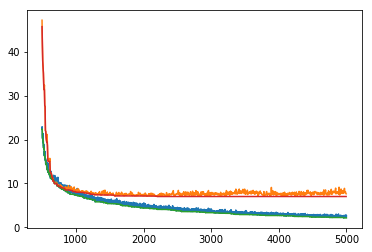

In [15]:
import matplotlib.pyplot as plt

train_df['loss'].loc[500:].plot()
test_df['loss'].loc[500:].plot()
train_df['min loss'].loc[500:].plot()
test_df['min loss'].loc[500:].plot()
print(test_df['min loss'].iloc[-1])

plt.show()

In [16]:
test_idx = np.flatnonzero(idx_split == 1)

predictions = results[-1].ravel()[test_idx]
actual = dataset[2].ravel()[test_idx]

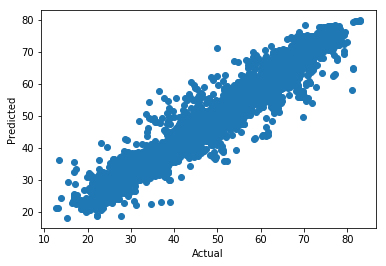

Max error:  23.091601316227496


In [17]:
plt.scatter(actual, predictions); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.show()
print('Max error: ', np.max(np.abs(actual - predictions)))

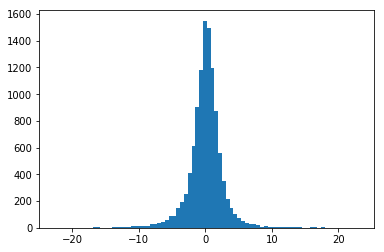

In [18]:
plt.hist(actual - predictions, bins = 80); plt.show()

In [19]:
import sklearn

sklearn.metrics.r2_score(predictions, actual)

0.9594218638137143

In [20]:
np.corrcoef(predictions, actual)

array([[1.     , 0.98213],
       [0.98213, 1.     ]])

In [12]:
### Save predictions
predictions_df = pd.DataFrame(np.hstack((results[-1], dataset[2].reshape((-1,1)), idx_split)), columns=['Prediction', 'Actual', 'idx_split'])
predictions_df.index = np.array(keys[0], dtype = int)
predictions_df.to_csv('PredictionsNoAuxilarySemisupervised.csv')

In [ ]:
predictions_df.head()